## <center> Multivariate Time Series with RNN </center>

Appliance Energy Usage: A Multivariate Time Series Forecasting Example

Experimental data used to create regression models of appliances energy use in a low energy building.
Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

Original source of the dataset:

http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('C:/Users/Lenovo/Desktop/Python/Deep Learning/Data Sets/TensorFlow/energydata_complete.csv',
                index_col='date', infer_datetime_format=True)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

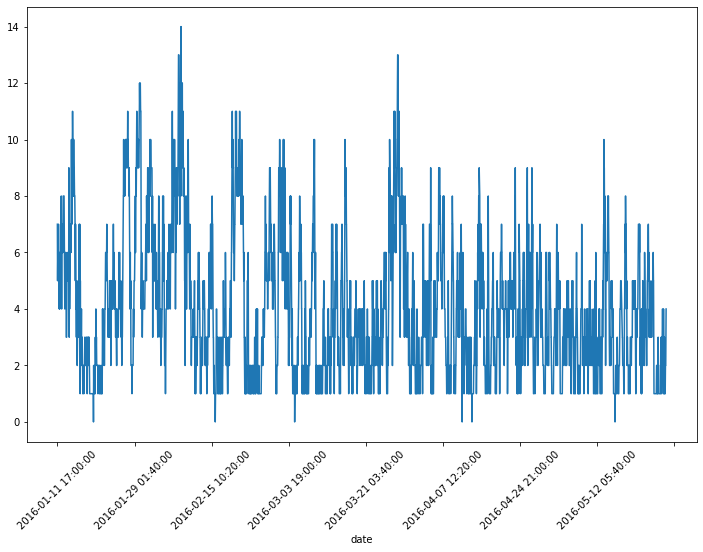

In [4]:
df['Windspeed'].plot(figsize=(12,8))
plt.xticks(rotation=45);

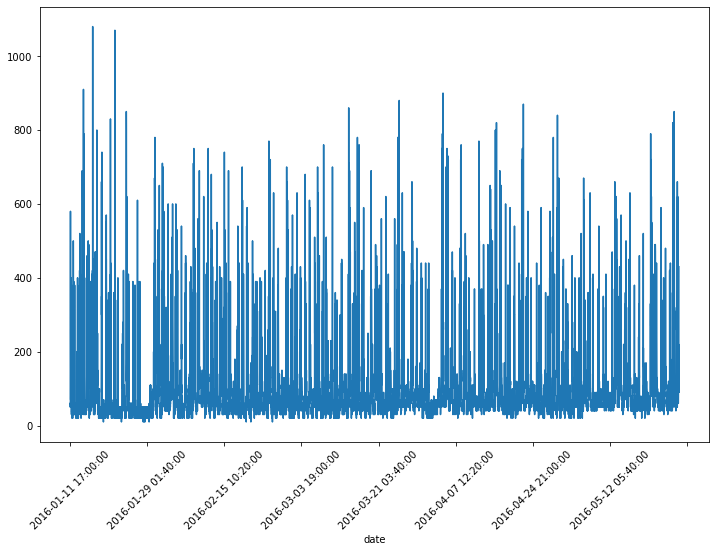

In [5]:
df['Appliances'].plot(figsize=(12,8))
plt.xticks(rotation=45);

#### Train, test split and scale

Let's imagine we want to predict just 24 hours into the future, we don't need 3 months of data for that, so let's save some training time and only select the last months data.

In [6]:
df = df.loc['2016-05-01':]

Let's also round off the data, to one decimal point precision, otherwise this may cause issues with our network (we will also normalize the data anyways, so this level of precision isn't useful to us)

In [7]:
df = df.round(2)

In [8]:
# How many rows per day? We know its every 10 min
24*60/10

144.0

In [9]:
test_days = 2
test_ind = test_days*144
test_ind

288

In [10]:
# Notice the minus sign in our indexing

train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

In [11]:
scaler = MinMaxScaler()

In [12]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

#### Time Series Generator

In [13]:
# define generator
length = 144 
batch_size = 1 
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [14]:
X,y = generator[0]

In [15]:
scaled_train[:length+1]

array([[0.03896104, 0.        , 0.13798978, ..., 0.21301775, 0.30618371,
        0.30618371],
       [0.05194805, 0.        , 0.12947189, ..., 0.21420118, 0.22473484,
        0.22473484],
       [0.03896104, 0.        , 0.12606474, ..., 0.2147929 , 0.43626176,
        0.43626176],
       ...,
       [0.05194805, 0.        , 0.30834753, ..., 0.14970414, 0.64078447,
        0.64078447],
       [0.03896104, 0.        , 0.30834753, ..., 0.14319527, 0.75185111,
        0.75185111],
       [0.03896104, 0.        , 0.30834753, ..., 0.13609467, 0.4576746 ,
        0.4576746 ]])

In [16]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03896104 0.         0.13798978 ... 0.14319527 0.75185111 0.75185111]
Predict this y: 
 [[0.03896104 0.         0.30834753 0.29439421 0.16038492 0.49182278
  0.0140056  0.36627907 0.24142857 0.24364791 0.12650602 0.36276002
  0.12       0.28205572 0.06169297 0.15759185 0.34582624 0.39585974
  0.09259259 0.39649608 0.18852459 0.96052632 0.59210526 0.1
  0.58333333 0.13609467 0.4576746  0.4576746 ]]


Now you will be able to edit the length so that it makes sense for your time series!

### Create the Model

In [17]:
scaled_train.shape

(3565, 28)

In [18]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               51600     
                                                                 
 dense (Dense)               (None, 28)                2828      
                                                                 
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


In [20]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

In [21]:
model.fit_generator(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/10


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15416\687208369.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=10,


3421/3421 [==============================] - 76s 22ms/step - loss: 0.0117 - val_loss: 0.0103
Epoch 2/10
3421/3421 [==============================] - 78s 23ms/step - loss: 0.0079 - val_loss: 0.0093
Epoch 3/10
3421/3421 [==============================] - 113s 33ms/step - loss: 0.0075 - val_loss: 0.0083
Epoch 4/10
3421/3421 [==============================] - 132s 39ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 5/10
3421/3421 [==============================] - 96s 28ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 6/10
3421/3421 [==============================] - 105s 31ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 7/10
3421/3421 [==============================] - 146s 43ms/step - loss: 0.0071 - val_loss: 0.0082


<AxesSubplot:>

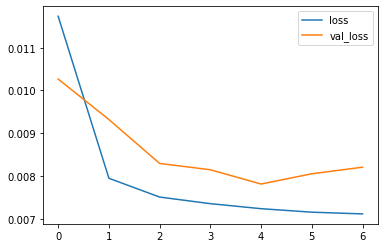

In [22]:
losses = pd.DataFrame(model.history.history)
losses.plot()

#### Evaluate on Test Data

In [23]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 34ms/step


#### Comparison

In [24]:
predictions = scaler.inverse_transform(test_predictions)

In [25]:
predictions = pd.DataFrame(data=predictions,columns=test.columns)

In [26]:
predictions

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,91.002998,2.071662,24.493291,37.649624,24.134268,35.536408,25.165970,36.945030,24.249399,37.386975,...,22.065723,37.161166,17.283989,756.017861,58.393247,2.034297,41.733174,8.064519,25.388649,25.158391
1,83.499364,2.926382,24.518330,37.644326,24.114783,35.714406,25.214475,37.052507,24.211194,37.265598,...,22.085695,37.024256,17.509327,755.833151,59.589059,1.930673,42.618386,8.551216,25.552696,25.639220
2,81.618219,3.439608,24.549985,37.739597,24.085251,35.961556,25.303132,37.176686,24.193693,37.280292,...,22.107003,36.941964,17.741302,755.679423,60.696986,1.816036,43.379368,9.054656,25.685094,25.802697
3,82.813225,3.705325,24.590290,37.864121,24.045368,36.227624,25.402940,37.280807,24.181478,37.356991,...,22.125438,36.865283,17.963769,755.538219,61.713304,1.690111,43.949248,9.535780,25.754676,25.933091
4,84.352827,3.822665,24.631542,38.038867,23.995357,36.544650,25.508809,37.376722,24.170788,37.498502,...,22.144390,36.816135,18.169251,755.416788,62.700027,1.558519,44.344430,9.996131,25.813667,26.056556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,98.749856,0.906744,24.500336,46.173083,23.235495,45.223677,26.135497,40.150213,24.888063,44.309148,...,23.561445,41.203155,26.231197,756.587350,45.262039,3.668236,47.597438,13.909096,27.890211,28.352701
284,98.655805,0.905429,24.500563,46.178937,23.231589,45.238438,26.135198,40.154173,24.887604,44.315332,...,23.562747,41.212339,26.220397,756.586471,45.312976,3.667433,47.603732,13.910981,27.890411,28.354339
285,98.572538,0.904085,24.500789,46.184761,23.227783,45.252959,26.135058,40.158002,24.887108,44.321460,...,23.564046,41.221184,26.210001,756.585486,45.362260,3.666809,47.610878,13.912770,27.890608,28.355918
286,98.500087,0.902719,24.501018,46.190526,23.224090,45.267215,26.135076,40.161700,24.886578,44.327525,...,23.565337,41.229686,26.200019,756.584389,45.409783,3.666362,47.618828,13.914473,27.890786,28.357437


In [27]:
RMSE = []

for col in test.columns:
    val_tue = test[col]
    val_up = predictions[col]
    rmse = np.sqrt(mean_squared_error(val_tue, val_up))

    RMSE.append(rmse)

np.mean(RMSE)

13.966477338395633